## Modules à importer

In [1]:
import math
import scipy
import pickle
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from snprop import age
from snprop import survey
from variaIa import tools
from variaIa.tools import surveys, df_cons, df_nc, df_c, df_full
from variaIa import massevol
from importlib import reload
from variaIa import stretchevol
from matplotlib.lines import Line2D
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
import random

## Définitions pandas, surveys et sélection de l'échantillon à utiliser

In [2]:
def set_survey(cons, su):
    global df
    if su == 'All':
        df = df_cons(cons)
    elif 'n' in su:
        df = df_cons(cons)[df_cons(cons)['survey'] != su.split('n')[-1]]
    else:
        df = df_cons(cons)[df_cons(cons)['survey'] == su]
    return df

int_set_su = ipw.interactive(set_survey, cons=tools.cons, su=tools.su)
display(int_set_su)

smap = plt.cm.get_cmap('cividis')
colors = {'SNF': plt.cm.binary(0.9),
          'SDSS': smap(0.1),
          'PS1': smap(0.5),
          'SNLS': smap(0.8),
          'HST': smap(0.99),  # for cividis
          #'HST': smap(300)}  # for viridis
          'All': (255/255, 51/255, 0/255)} 

def alphacolors(alpha, survey):
    return(colors[survey][0], colors[survey][1], colors[survey][2], alpha)

df_nHST = df_nc[df_nc['survey'] != 'HST']

interactive(children=(Checkbox(value=False, description='Conservative'), Dropdown(description='Survey:', optio…

## Use of `massevol` to determine a mass/age relationship

In [3]:
gen = massevol.generic()
gen.set_model('Evol3G3M4S')
evol3G3M4S = gen.fit(df, limit_a=(0, 1), limit_mu_2=(8, 10), limit_mu=(10, 11))

gen.set_model('Evol3G3M3S')
evol3G3M3S = gen.fit(df, limit_a=(0,1))

gen.set_model('Evol2G2M3S')
evol2G2M3S = gen.fit(df)

gen.set_model('Evol2G2M2S')
evol2G2M2S = gen.fit(df)

gen.set_model('Evol1G1M2S')
evol1G1M2S = gen.fit(df)

gen.set_model('Evol1G1M1S')
evol1G1M1S = gen.fit(df)

mod_list = [evol1G1M1S, evol1G1M2S, evol2G2M2S, evol2G2M3S, evol3G3M3S, evol3G3M4S]
mod_name = ['Evol'+mod.__doc__ for mod in mod_list]

pp = PrettyPrinter()
for mod in mod_list:
    print(mod.__doc__)
    pp.pprint(mod.param)

/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Gaussian
{'mu': 9.899600471198278, 'sigma': 0.816644619857764}
Asym
{'mu': 10.495149912291202,
 'sigmadown': 1.157631431963404,
 'sigmaup': 0.4171284597726203}
2G2M2S
{'mu_1': 9.355305737211426,
 'mu_2': 10.58210079108396,
 'sigma_1': 0.6433441769250937,
 'sigma_2': -0.38393439486087133}
2G2M3S
{'mu': 10.67620053469842,
 'mu_1': 9.368589148610129,
 'sigma_1': -0.6535418908596325,
 'sigmadown': 0.5400359966320671,
 'sigmaup': 0.3491354618293428}
3G3M3S
{'a': 0.902710356796472,
 'mu_1': 9.42435033203514,
 'mu_2': 10.59321817727873,
 'mu_3': 8.74496390066,
 'sigma_1': 0.6352164641545026,
 'sigma_2': 0.3739487056160915,
 'sigma_3': 0.42788950723936164}
3G3M4S
{'a': 0.20406215756841461,
 'mu': 10.654561570801503,
 'mu_1': 9.417915376919256,
 'mu_2': 9.77714568581221,
 'sigma_1': 0.6371659572533067,
 'sigma_2': 1.0585822206877296,
 'sigmadown': 0.36535052704112453,
 'sigmaup': 0.28408381713363023}


In [70]:
for name, model in zip(mod_name[2:], mod_list[2:]):
    fig = plt.figure(figsize=[7, 3.5])
    ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])
    axh = fig.add_axes([0.75, 0.12, 0.2, 0.8])
 
    print(name)
    gen.set_model(name)
    mod = gen.model(df)
    mod.param = model.param
    mod.scatter(ax=ax, model=False)
    mod.show_hist(ax=axh)
    mod.show_model(ax=axh,
                   o_factor=-mod.amp*np.sum(1-mod.py),
                   y_factor=mod.amp*np.sum(mod.py),
                   facealpha=0, edgealpha=1, lw=1, zorder=8)
    
    axh.set_ylim(*ax.get_ylim())
    axh.set_yticks([])
    axh.set_xticks([])
    
    axh.axvline(0, color='k', lw=1, zorder=10)
    
    axh.set_frame_on(False)
    
    plt.close()

    fig.savefig('../../../Images/pdf/model_mass_' + mod.__doc__ + '_hist.pdf',
                bbox_inches='tight')
    #fig.savefig('../../../Images/png/model_mass_' + mod.__doc__ + '_hist.png',
    #            bbox_inches='tight', dpi=600)
    

Evol2G2M2S
Evol2G2M3S
Evol3G3M3S
Evol3G3M4S


## Individual mass histogram

Text(0, 0.5, '$\\mathrm{N}_\\mathrm{SNe Ia}$ ')

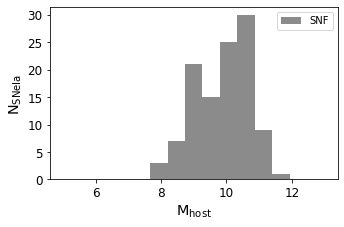

In [7]:
fig = plt.figure(figsize=[5, 3])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

ax.hist(df.hostmass,
        range=[5, 13], bins=15,
        histtype='stepfilled',
        color=colors[tools.su.value],
        alpha=.5, lw=2, label=tools.su.value)

ax.tick_params(labelsize=12)

ax.legend()

ax.set_xlabel(r"$\mathrm{M}_\mathrm{host}$", fontsize="x-large")
ax.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$ ", fontsize="x-large")

### Means of each

In [8]:
for survey in surveys[:-1]:
    df_temp = set_survey(0, survey)
    print('Survey:', survey,
          'Mean:', np.mean(df_temp[df_temp['hostmass'] > 6]['hostmass']),
          'std:', np.std(df_temp[df_temp['hostmass'] > 6]['hostmass']))
print('Survey:', 'All',
      'Mean:', np.mean(df_nc[df_nc['hostmass'] > 6]['hostmass']),
      'Std:', np.std(df_nc[df_nc['hostmass'] > 6]['hostmass']))

Survey: SNF Mean: 9.876485910136639 std: 0.8332716664933211
Survey: SDSS Mean: 10.327451612903229 std: 0.7088936786702846
Survey: PS1 Mean: 10.154978571428567 std: 0.9427213093000224
Survey: SNLS Mean: 9.81382 std: 0.9153911992148492
Survey: All Mean: 10.077460871840966 Std: 0.8535895436547255


## Total mass fitting tests

## One Gauss

In [16]:
def gauss(c, dc, mu, sigma, normed=True):
    '''Le modèle de distribution'''
    sigma_eff = np.sqrt(dc**2+sigma**2)
    norm = 1 if normed else np.sqrt(2*np.pi)*sigma_eff
    return norm*scipy.stats.norm.pdf(c, mu, scale=sigma_eff)

def loglikelihood_gauss(mu, sigma):
    '''La fonction à minimiser'''
    return -2*np.sum(np.log(gauss(df.colors, df.colors_err,
                                  mu, sigma)))

def minimize_gauss(print_level=0, **kwargs):
    '''Renvoie la meilleure valeur des paramètres'''
    m_tot = im.Minuit(loglikelihood_gauss,
                      print_level=print_level,
                      pedantic=False,
                      mu=0, sigma=1,
                      **kwargs)
    migrad_out = m_tot.migrad()
    return(m_tot)

bestfit_gauss = minimize_gauss().values
bestfit_gauss

<ValueView of Minuit at 56468a2ca510>
  mu: -0.00030893241013408386
  sigma: 0.06391450800329923

{'mu': 10.121863006396344, 'sigma': 0.8118852237092443}


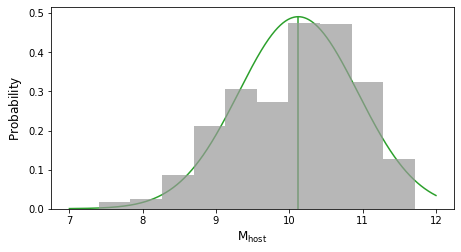

In [3]:
gen = massevol.generic()
gen.set_model('Evol1G1M1S')
mean_test = gen.fit(df_nc[df_nc['hostmass'] > 7])

print(mean_test.param)
mean_test.show_model_tot()

### One asym

In [18]:
def gauss(M, mu, sigma, normed=True):
    '''Le modèle de distribution'''
    sigma_eff = np.sqrt(sigma**2)
    norm = 1 if normed else np.sqrt(2*np.pi)*sigma_eff
    return norm*scipy.stats.norm.pdf(M, mu, scale=sigma_eff)

def likelihood_asym(M, mu, sigma_m, sigma_p):
    '''La fonction prenant en compte la probabilité d'être vieille/jeune'''
    flag_up = M >= mu
    likelihood = np.zeros(len(M))
    likelihood[flag_up] = gauss(M[flag_up],
                                mu, sigma_p, normed=False)
    likelihood[~flag_up] = gauss(M[~flag_up],
                                 mu, sigma_m, normed=False)
    norm = np.sqrt(2*np.pi)*(0.5*np.sqrt(sigma_m**2)
                             + 0.5*np.sqrt(sigma_p**2))
    return likelihood/norm

def loglikelihood_asym(mu, sigma_m, sigma_p):
    '''La fonction à minimiser'''
    return -2*np.sum(np.log(likelihood_asym(df_nHST[df_nHST['hostmass'] > 7].hostmass,
                                            mu,
                                            sigma_m, sigma_p)))

def minimize_asym(print_level=0, **kwargs):
    '''Renvoie la meilleure valeur des paramètres'''
    m_tot = im.Minuit(loglikelihood_asym,
                      print_level=print_level,
                      pedantic=False,
                      mu=10, sigma_m=2, sigma_p=1,
                      **kwargs)
    migrad_out = m_tot.migrad()
    return(m_tot)

bestfit_asym = minimize_asym().values
bestfit_asym

/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log


<ValueView of Minuit at 564689c7cf50>
  mu: -0.032727889743877754
  sigma_m: 0.04583173064572729
  sigma_p: 0.08862562820582792

### One asym one Gauss

In [20]:
def likelihood_gauss(M, mu_2, sigma_2):
    '''La fonction décrivant le modèle des SNe vieilles'''
    return gauss(M, mu_2, sigma_2)
                                                                            
def likelihood_asymgauss(a, M, mu, sigma_m, sigma_p, mu_2, sigma_2):
    '''La fonction prenant en compte la probabilité d'être vieille/jeune'''
    return a*likelihood_asym(M, mu, sigma_m, sigma_p) + \
        (1-a)*likelihood_gauss(M, mu_2, sigma_2)
                                                                            
def loglikelihood_asymgauss(a, mu, sigma_m, sigma_p, mu_2, sigma_2):
    '''La fonction à minimiser'''
    return -2*np.sum(np.log(likelihood_asymgauss(a,
                                                 df_nHST[df_nHST['hostmass'] > 7].hostmass,
                                                 mu, sigma_m, sigma_p,
                                                 mu_2, sigma_2)))

def minimize_asymgauss(print_level=0, **kwargs):
    '''Renvoie la meilleure valeur des paramètres'''
    m_tot = im.Minuit(loglikelihood_asymgauss,
                      print_level=print_level,
                      pedantic=False,
                      a=0.5,
                      mu=8, sigma_m=1, sigma_p=0.5,
                      mu_2=11, sigma_2=1,
                      **kwargs)
    migrad_out = m_tot.migrad()
    return(m_tot)

bestfit_asymgauss = minimize_asymgauss().values

### Plotting the tests

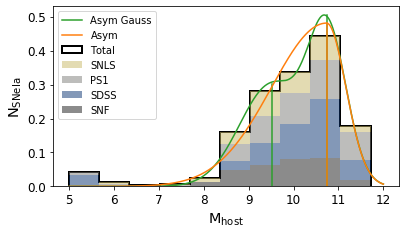

In [21]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.6, 0.5])
    
stacked_bt = [df_nHST[df_nHST['survey'] == survey].hostmass for survey in surveys[:-1]]
hstclrs_bt = [list(alphacolors['5'].values())[i] for i in range(len(surveys[:-1]))]

ax.hist(df_nHST.hostmass,
        density=True,
        bins=10,
        histtype='step',
        lw=2, color='k',
        label='Total')

_, rang, _ = ax.hist(stacked_bt,
                     density=True,
                     stacked=True,
                     bins=10,
                     histtype='stepfilled',
                     color=hstclrs_bt,
                     label=surveys)

ax.tick_params(labelsize=12)

ax.set_xlabel(r'$\mathrm{M}_\mathrm{host}$', fontsize = 'x-large')
ax.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize="x-large")

ax.legend(loc='upper left', fontsize='medium', ncol=1)

path = '../../Images/'
name = 'mass-cut_hist_stac'
pathpdf = path + 'pdf/' + name + '.pdf'
pathpng = path + 'png/' + name + '.png'
fig.savefig(pathpdf, bbox_inches='tight')
fig.savefig(pathpng, bbox_inches='tight', dpi=600)

M_lin = np.linspace(rang[0], 12, 3000)

pdf_asymgauss = likelihood_asymgauss(bestfit_asymgauss['a'],
                                     M_lin,
                                     bestfit_asymgauss['mu'],
                                     bestfit_asymgauss['sigma_m'],
                                     bestfit_asymgauss['sigma_p'],
                                     bestfit_asymgauss['mu_2'],
                                     bestfit_asymgauss['sigma_2'])
ax.plot(M_lin, pdf_asymgauss,
        color='C2', label='Asym Gauss')

ax.vline(bestfit_asymgauss['mu'],
         color='C2',
         ymin=0, ymax=bestfit_asymgauss['a']*\
                      np.max(likelihood_asym(M_lin,
                                             bestfit_asymgauss['mu'],
                                             bestfit_asymgauss['sigma_m'],
                                             bestfit_asymgauss['sigma_p'])))

ax.vline(bestfit_asymgauss['mu_2'],
         color='C2',
         ymin=0, ymax=np.max(pdf_asymgauss))

pdf_asym = likelihood_asym(M_lin,
                           bestfit_asym['mu'],
                           bestfit_asym['sigma_m'],
                           bestfit_asym['sigma_p'])

ax.plot(M_lin, pdf_asym,
        color='C1', label='Asym')
ax.vline(bestfit_asym['mu'],
         color='C1',
         ymin=0, ymax=np.max(pdf_asym))

ax.legend(loc='upper left', fontsize='medium', ncol=1)

path = '../../Images/'
name = 'mass-cut_hist_stac-fit'
pathpdf = path + 'pdf/' + name + '.pdf'
pathpng = path + 'png/' + name + '.png'
fig.savefig(pathpdf, bbox_inches='tight')
fig.savefig(pathpng, bbox_inches='tight', dpi=600)